# **Pokemón Diffusion Overfitting<a id="top"></a>**

<i><small>**Alumno:** Alejandro Pequeño Lizcano</small></i></div>

---

**Objetivo:** 
Este notebook tiene como objetivo forzar el overfitting de un modelo de difusión para poder analizar su comportamiento y entender cómo se comporta en un entorno controlado y poder arreglar posibles fallos en el código.

- [0. Imports](#-0.-Imports)

- [1. Dataset](#-1.-Dataset)
    - [1.1. Predataset](##-1.1.-Predataset)
    - [1.2. Dataset](##-1.2.-Dataset)

- [2. Modelo de Difusión](#-2.-Modelo-de-Difusión)
    - [2.1. Forward Diffusion](##-2.1.-Forward-Diffusion)
    - [2.2. Reverse Diffusion](##-2.2.-Reverse-Diffusion)
    - [2.3. Train Diffusion Model](##-2.3.-Train-Diffusion-Model)

---

# 0. Imports

In [9]:
# Import necessary libraries
# =====================================================================

# Import visualization libraries
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Import libraries for data preprocessing
import numpy as np
import pandas as pd
from tqdm.auto import trange, tqdm  # progress bar

# Import libraries for data and folder manipulation
import random
import os
import sys
import json
import re
import glob

# Import libraries from tensorflow for building the model
import tensorflow as tf
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras import layers
import gc
from sklearn.preprocessing import LabelBinarizer

# Import necessary libraries
# =====================================================================
import os

os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"

import configparser
import tensorflow as tf

# Import src code
from src.data.create_dataset import *
from src.model.build_unet import build_unet
from src.utils.utils import PROJECT_DIR, DATA_PATH
from src.visualization import visualize

# from src.model.diffusion_model import *
from src.model.overfitting_test import *

In [10]:
# Use the GPU
# =====================================================================
gpus_list = tf.config.list_physical_devices("GPU")
gpu = gpus_list[0]
tf.config.experimental.set_memory_growth(gpu, True)

print("GPUs Available: ", gpus_list)

GPUs Available:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [11]:
# Set config file
# =====================================================================
config = configparser.ConfigParser()
config.read(PROJECT_DIR / "config.ini")

# Hyperparameters
config_hp = config["hyperparameters"]

IMG_SIZE = 64
NUM_CLASSES = int(config_hp["num_classes"])
BATCH_SIZE = 32
EPOCHS = int(config_hp["epochs"])
T = 300
BETA_START = float(config_hp["beta_start"])
BETA_END = float(config_hp["beta_end"])
s = float(config_hp["s"])  # scale factor for the variance curve
SCHEDULER = config_hp["scheduler"]

optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)  # TODO: ADD TO CONFIG FILE
loss_fn = tf.keras.losses.MeanSquaredError()

In [12]:
# load df and data_dict
# =====================================================================
path = f"{DATA_PATH}/processed/pokedex_cleaned.csv"
df = pd.read_csv(path)

with open(f"{DATA_PATH}/interim/pokemon_dict_dataset.json", "r") as f:
    data_dict = json.load(f)

from src.data.path_loader import PathLoader as pl

loader = pl(
    load_pattern=f"{DATA_PATH}/raw/sprites/**/front/**/*.png",
)

# Load the paths from the file
image_paths = loader.load_paths()

from src.data.create_dataset import dataset_dict

data_dict = dataset_dict(image_paths=image_paths, df=df)

Loading paths...

- Number of paths loaded: 8143



/usr/local/lib/python3.11/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(
2024-04-14 18:01:52.562161: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


- The shape of the dataset is: (32, 64, 64, 3) => batch_size: 32, height: 64, width: 64, channels: 3
- The shape of the dataset labels is: (32, 18) => batch_size: 32, number of labels: 18


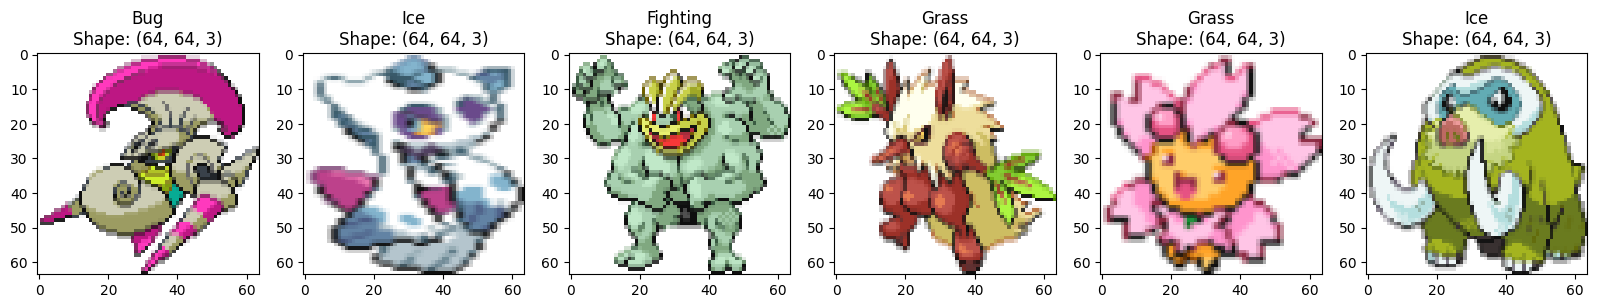

2024-04-14 18:01:53.132468: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [13]:
# dataset_path = f"{DATA_PATH}/processed/pokemon_tf_dataset"
# poke_dataset = tf.data.Dataset.load(path=dataset_path, compression="GZIP")

poke_dataset = dataset_tf(
    df=df,
    dict_dataset=data_dict,
    img_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
)

# Check the dataset
# =====================================================================
for img, label in poke_dataset.take(1):
    print(
        f"- The shape of the dataset is: {img.shape} => batch_size: {img.shape[0]}, height: {img.shape[1]}, width: {img.shape[2]}, channels: {img.shape[3]}"
    )
    print(
        f"- The shape of the dataset labels is: {label.shape} => batch_size: {label.shape[0]}, number of labels: {label.shape[1]}"
    )

# Visualize the dataset
visualize.plot_images_batch(dataset_tf=poke_dataset, n=6)

<class 'tensorflow.python.framework.ops.EagerTensor'> <class 'tensorflow.python.framework.ops.EagerTensor'>
(32, 64, 64, 3)
(32, 18)


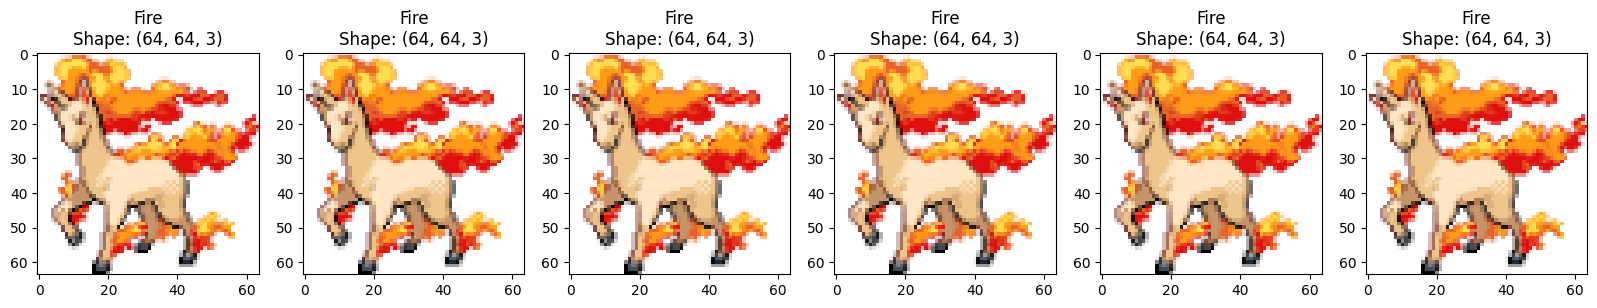

2024-04-14 18:01:53.618696: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-04-14 18:01:53.619587: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [14]:
# get one batch of the dataset
dataset_example = poke_dataset.take(1)

# get one specific image of the batch
for img, label in dataset_example:
    img_example = img[0]
    label_example = label[0]
    break

# get only one image of the dataset
for img, label in dataset_example:
    img_example = img[0]
    label_example = label[0]
    break

img_example = np.expand_dims(img_example, axis=0)  # expand the image to the batch size
label_example = np.expand_dims(
    label_example, axis=0
)  # expand the label to the batch size

dataset_example = tf.data.Dataset.from_tensor_slices((img_example, label_example))

dataset_example = dataset_example.repeat(256).batch(BATCH_SIZE)

for img, label in dataset_example:
    print(type(img), type(label))
    print(img.shape)
    print(label.shape)
    break

for img, label in dataset_example.take(1):
    visualize.plot_images_batch(dataset_tf=dataset_example)

In [15]:
# Create the model
# =====================================================================
u_net = build_unet(IMG_SIZE, NUM_CLASSES)
loss_fn = tf.keras.losses.MeanSquaredError()
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)

model = DiffusionModel(
    u_net, IMG_SIZE, NUM_CLASSES, T, BETA_START, BETA_END, s, SCHEDULER
)

# Compile the model
# =====================================================================
model.compile(loss=loss_fn, optimizer=optimizer)

Epoch 1/100


2024-04-14 18:01:55.240798: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 4.33GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 319ms/step - loss: 3.0140
Epoch 2/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 316ms/step - loss: 0.9728
Epoch 3/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 318ms/step - loss: 1.0658
Epoch 4/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 318ms/step - loss: 3.0807

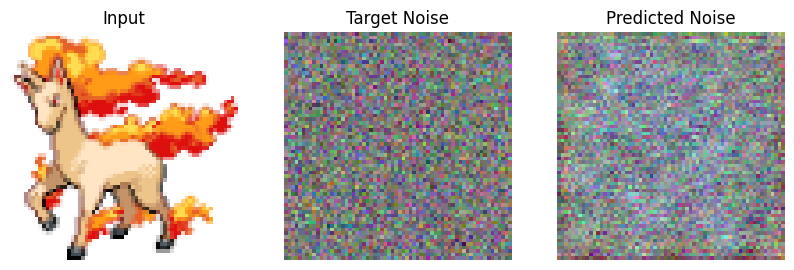

8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 329ms/step - loss: 2.7384
Epoch 5/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 319ms/step - loss: 1.4043
Epoch 6/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 315ms/step - loss: 61.6776
Epoch 7/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 318ms/step - loss: 5.8150
Epoch 8/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 325ms/step - loss: 0.5947

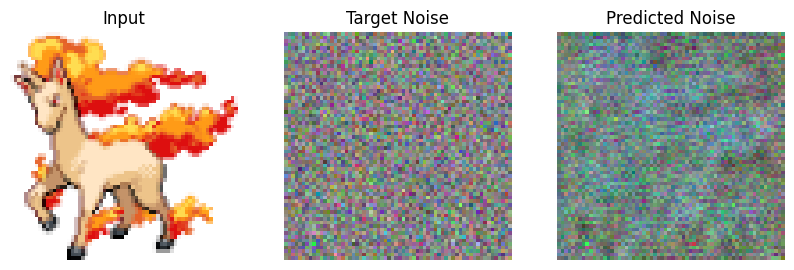

8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 335ms/step - loss: 0.5286
Epoch 9/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 334ms/step - loss: 30.0052
Epoch 10/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 328ms/step - loss: 3.0169
Epoch 11/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 329ms/step - loss: 88.6728
Epoch 12/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 330ms/step - loss: 7.0908

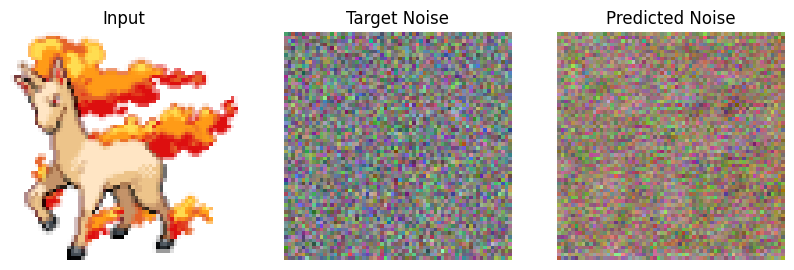

8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 340ms/step - loss: 6.3029
Epoch 13/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 336ms/step - loss: 25.9951
Epoch 14/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 316ms/step - loss: 0.3472
Epoch 15/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 321ms/step - loss: 1.2444
Epoch 16/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 327ms/step - loss: 0.3767

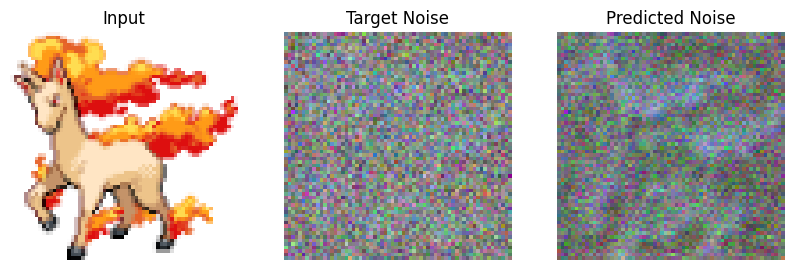

8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 338ms/step - loss: 0.3348
Epoch 17/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 323ms/step - loss: 0.3856
Epoch 18/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 316ms/step - loss: 0.8242
Epoch 19/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 318ms/step - loss: 0.2754
Epoch 20/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 314ms/step - loss: 0.3475

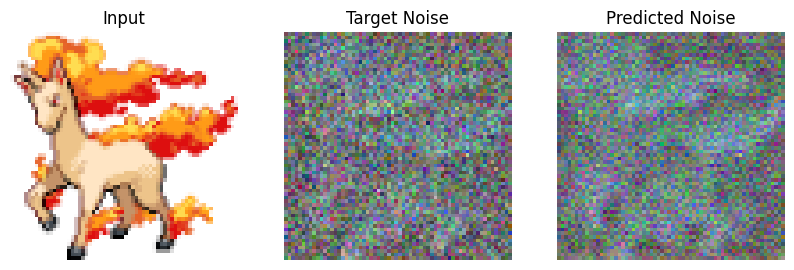

Epoch 20: Generating samples.
Generating sample 1/1


Sampling sprite: 100%|██████████| 299/299 [00:13<00:00, 22.69it/s]


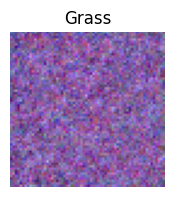

8/8 ━━━━━━━━━━━━━━━━━━━━ 16s 2s/step - loss: 0.3089  
Epoch 21/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 315ms/step - loss: 0.2342
Epoch 22/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 310ms/step - loss: 0.3311
Epoch 23/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 320ms/step - loss: 1.0468
Epoch 24/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 312ms/step - loss: 0.2875

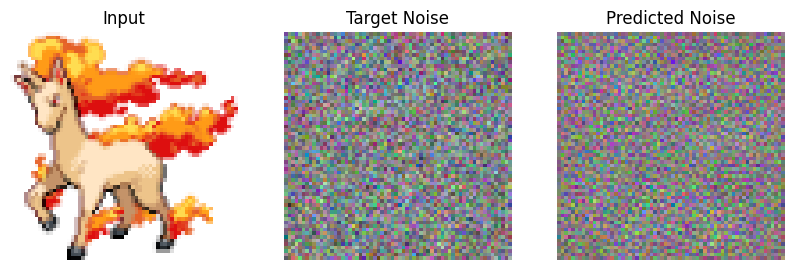

8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 322ms/step - loss: 0.2555
Epoch 25/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 312ms/step - loss: 51.8470
Epoch 26/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 316ms/step - loss: 0.4600
Epoch 27/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 311ms/step - loss: 7.2392
Epoch 28/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 311ms/step - loss: 6.0553

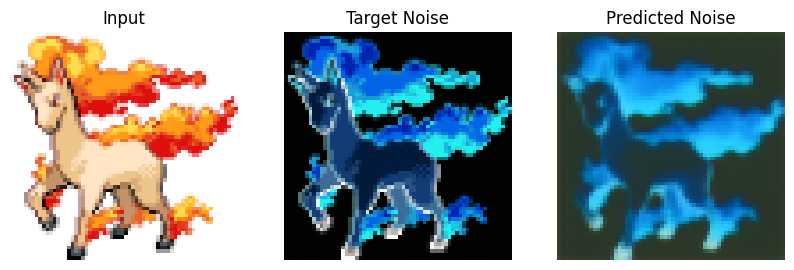

8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 321ms/step - loss: 5.3825
Epoch 29/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 314ms/step - loss: 0.4842
Epoch 30/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 324ms/step - loss: 1.0910
Epoch 31/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 317ms/step - loss: 0.2237
Epoch 32/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 318ms/step - loss: 151.7815

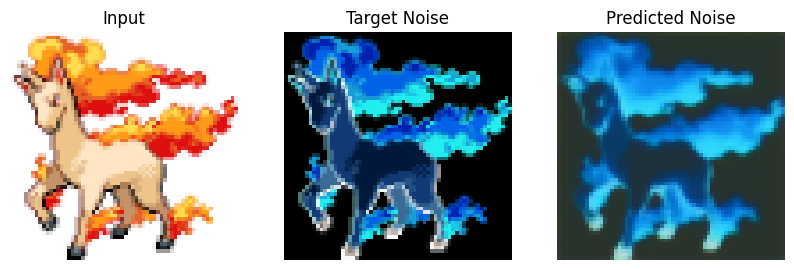

8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 328ms/step - loss: 134.9169
Epoch 33/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 318ms/step - loss: 1.3817
Epoch 34/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 311ms/step - loss: 0.1830
Epoch 35/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 315ms/step - loss: 84.2488
Epoch 36/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 312ms/step - loss: 0.7107

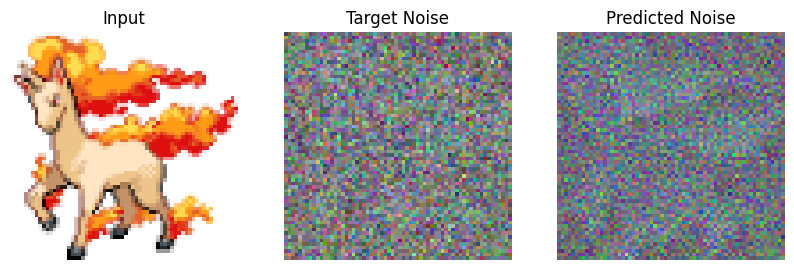

8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 322ms/step - loss: 0.6318
Epoch 37/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 316ms/step - loss: 161.7268
Epoch 38/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 316ms/step - loss: 0.2450
Epoch 39/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 315ms/step - loss: 84.8775
Epoch 40/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 315ms/step - loss: 60.7706

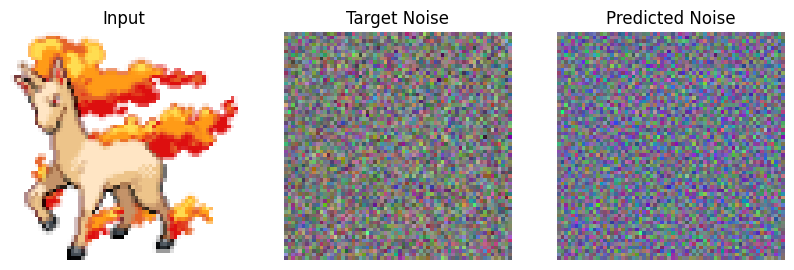

Epoch 40: Generating samples.
Generating sample 1/1


Sampling sprite: 100%|██████████| 299/299 [00:12<00:00, 23.56it/s]


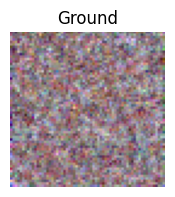

8/8 ━━━━━━━━━━━━━━━━━━━━ 16s 2s/step - loss: 54.0183  
Epoch 41/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 313ms/step - loss: 0.3958
Epoch 42/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 313ms/step - loss: 9.0683 
Epoch 43/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 309ms/step - loss: 49.5410
Epoch 44/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 310ms/step - loss: 36.1677

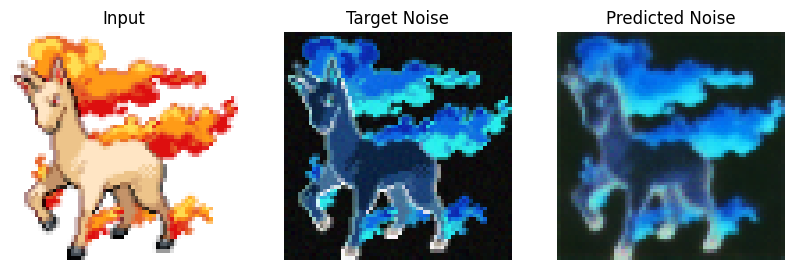

8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 321ms/step - loss: 32.1491
Epoch 45/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 316ms/step - loss: 0.1389
Epoch 46/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 311ms/step - loss: 0.4019
Epoch 47/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 319ms/step - loss: 1.3421
Epoch 48/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 317ms/step - loss: 6.9194

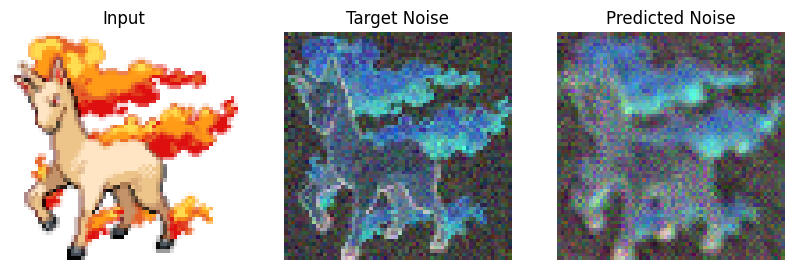

8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 327ms/step - loss: 6.1506
Epoch 49/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 311ms/step - loss: 8.1064
Epoch 50/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 311ms/step - loss: 0.2740
Epoch 51/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 310ms/step - loss: 81.1969
Epoch 52/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 312ms/step - loss: 6.7203

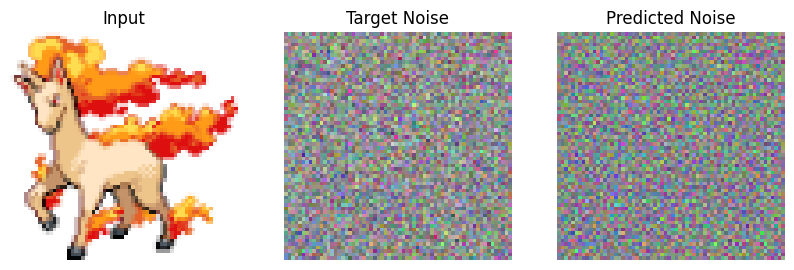

8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 322ms/step - loss: 5.9736
Epoch 53/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 308ms/step - loss: 0.3279
Epoch 54/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 310ms/step - loss: 0.3631
Epoch 55/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 312ms/step - loss: 153.7336
Epoch 56/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 312ms/step - loss: 0.1900

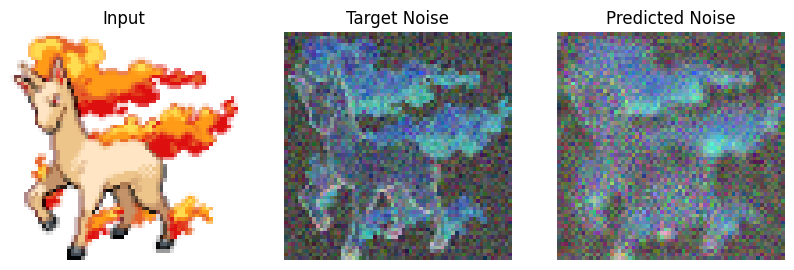

8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 322ms/step - loss: 0.1689
Epoch 57/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 313ms/step - loss: 4.9226
Epoch 58/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 313ms/step - loss: 0.2330
Epoch 59/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 311ms/step - loss: 0.2201
Epoch 60/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 311ms/step - loss: 0.2122

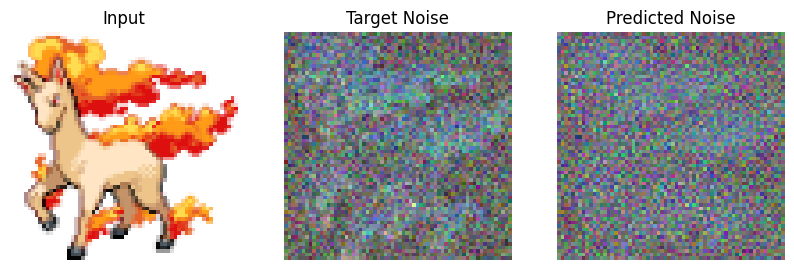

Epoch 60: Generating samples.
Generating sample 1/1


Sampling sprite: 100%|██████████| 299/299 [00:12<00:00, 23.84it/s]


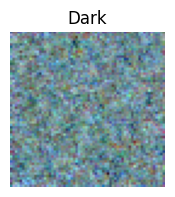

8/8 ━━━━━━━━━━━━━━━━━━━━ 16s 2s/step - loss: 0.1886  
Epoch 61/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 316ms/step - loss: 0.1860
Epoch 62/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 313ms/step - loss: 0.1711
Epoch 63/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 317ms/step - loss: 1.1229
Epoch 64/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 322ms/step - loss: 0.1383

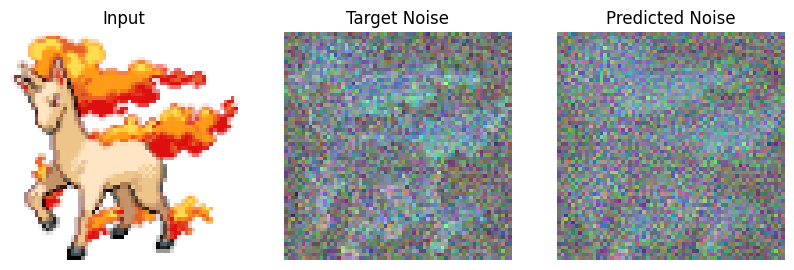

8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 333ms/step - loss: 0.1229
Epoch 65/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 318ms/step - loss: 401.1299
Epoch 66/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 317ms/step - loss: 48.3324
Epoch 67/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 317ms/step - loss: 0.1984
Epoch 68/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 319ms/step - loss: 0.3055

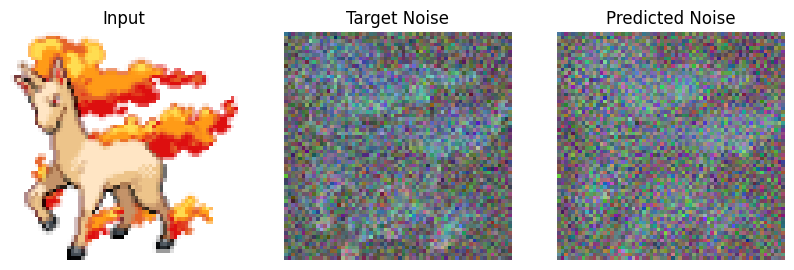

8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 330ms/step - loss: 0.2716
Epoch 69/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 318ms/step - loss: 0.2134
Epoch 70/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 317ms/step - loss: 0.1632
Epoch 71/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 312ms/step - loss: 0.1176
Epoch 72/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 313ms/step - loss: 0.4594

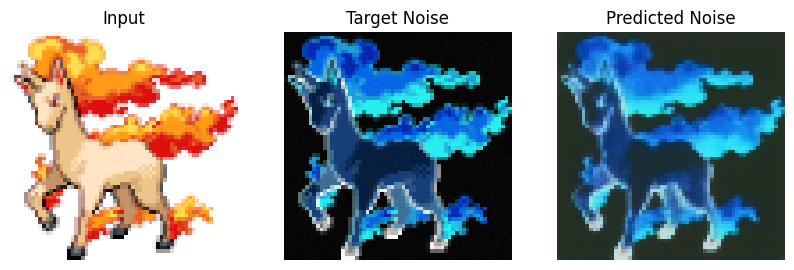

8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 324ms/step - loss: 0.4084
Epoch 73/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 317ms/step - loss: 0.6689
Epoch 74/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 314ms/step - loss: 24.9387
Epoch 75/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 319ms/step - loss: 2.1215
Epoch 76/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 311ms/step - loss: 3.4612

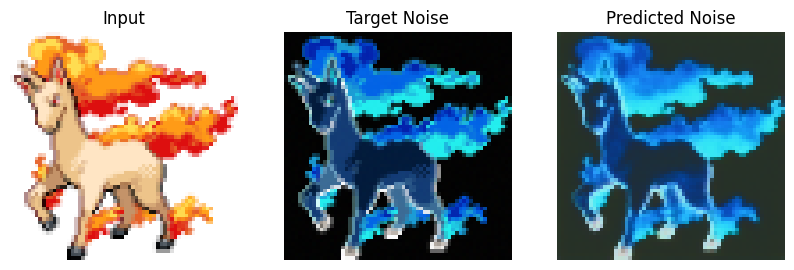

8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 323ms/step - loss: 3.0766
Epoch 77/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 314ms/step - loss: 0.1321
Epoch 78/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 309ms/step - loss: 1.0200
Epoch 79/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 311ms/step - loss: 151.9448
Epoch 80/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 311ms/step - loss: 53.2951

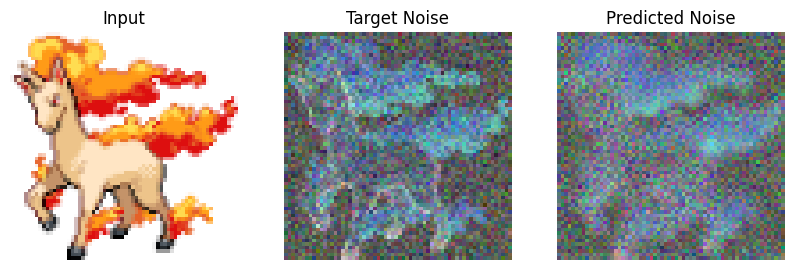

Epoch 80: Generating samples.
Generating sample 1/1


Sampling sprite: 100%|██████████| 299/299 [00:12<00:00, 23.25it/s]


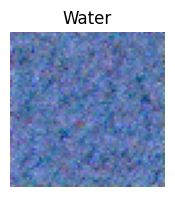

8/8 ━━━━━━━━━━━━━━━━━━━━ 16s 2s/step - loss: 47.3734  
Epoch 81/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 323ms/step - loss: 398.9619
Epoch 82/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 319ms/step - loss: 1.2812
Epoch 83/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 315ms/step - loss: 0.1247
Epoch 84/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 321ms/step - loss: 0.1373

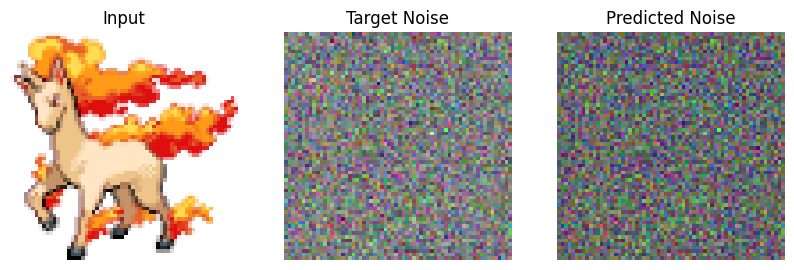

8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 332ms/step - loss: 0.1221
Epoch 85/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 317ms/step - loss: 78.8235
Epoch 86/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 317ms/step - loss: 0.0947
Epoch 87/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 318ms/step - loss: 150.8301
Epoch 88/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 316ms/step - loss: 446.7669

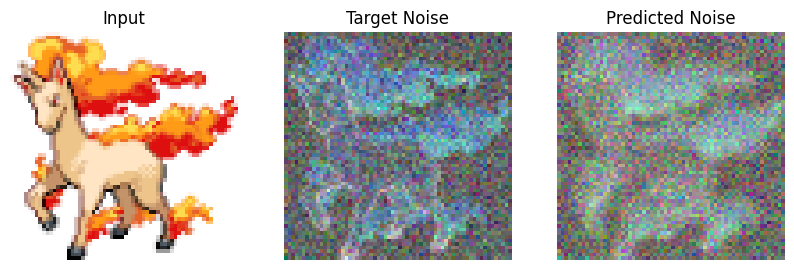

8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 327ms/step - loss: 397.1262
Epoch 89/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 317ms/step - loss: 0.1345
Epoch 90/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 315ms/step - loss: 5.8412
Epoch 91/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 314ms/step - loss: 0.1461
Epoch 92/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 322ms/step - loss: 0.1805

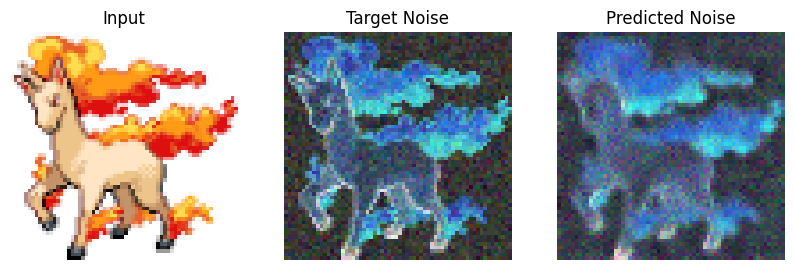

8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 332ms/step - loss: 0.1604
Epoch 93/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 318ms/step - loss: 1.7691
Epoch 94/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 315ms/step - loss: 78.6669
Epoch 95/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 323ms/step - loss: 0.1371
Epoch 96/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 321ms/step - loss: 0.4108

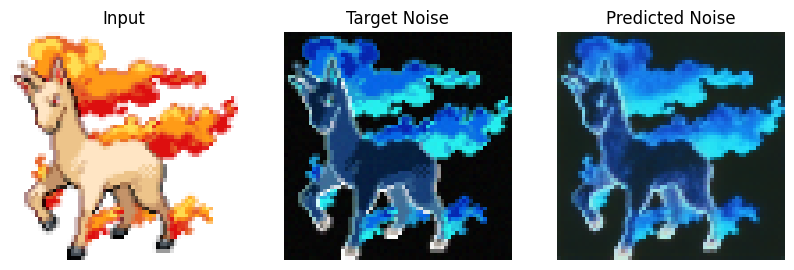

8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 332ms/step - loss: 0.3651
Epoch 97/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 315ms/step - loss: 9.8639 
Epoch 98/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 318ms/step - loss: 77.6824
Epoch 99/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 318ms/step - loss: 0.1577
Epoch 100/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 320ms/step - loss: 0.1909

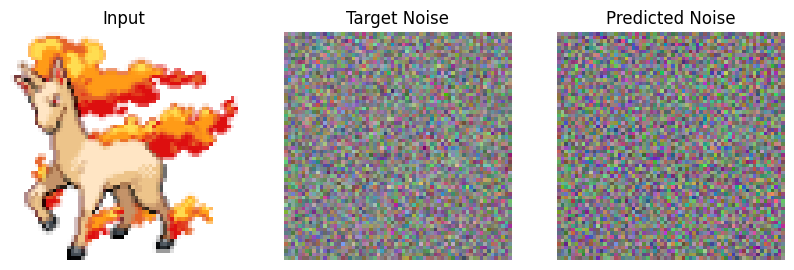

Epoch 100: Generating samples.
Generating sample 1/1


Sampling sprite: 100%|██████████| 299/299 [00:12<00:00, 23.99it/s]


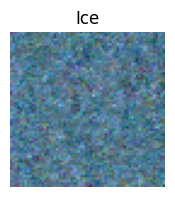

8/8 ━━━━━━━━━━━━━━━━━━━━ 16s 2s/step - loss: 0.1697  


In [16]:
tf.config.run_functions_eagerly(True)  # to debug the model
model.fit(
    dataset_example,
    epochs=EPOCHS,
    callbacks=[PlottingCallback(model, 4), DiffusionCallback(model, 20)],
)
# model.fit(poke_dataset, epochs=EPOCHS, callbacks=[DiffusionCallback(model, 10)])

Generating sample 1/1


Sampling sprite: 100%|██████████| 299/299 [00:13<00:00, 22.96it/s]


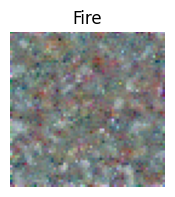

In [19]:
model.plot_samples(1, "Fire")

In [18]:
# df = preprocess.load_csv("../../dataset/pokedex.csv")
# data_path = preprocess.load_paths_from_file("../../dataset/image_paths.json")
# data_dict = preprocess.dataset_dict(data_path, df)
# dataset = preprocess.create_dataset(data_dict, df, size=IMG_SIZE, batch_size=BATCH_SIZE)
# label_mappping = preprocess.create_label_mapping(df)

# def generate_em(num_classes: int = NUM_CLASSES) -> np.ndarray:
#     """Generates a random embedding (label)

#     :param num_classes: The number of classes
#     """

#     em = np.zeros(num_classes)
#     em[np.where(label_example[0] == 1)[0][0]] = 1
#     return em


# generate_em()
# plotter.onehot_to_string(generate_em(), label_mappping)